# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import importlib
from collections import deque
import matplotlib.pyplot as plt
import torch
import os


In [2]:
# Flag for training agent, or simply running the saved agent.
TRAIN_AGENT = True


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
env = UnityEnvironment(file_name="./Tennis.app")


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [6]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step      
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [7]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```


Idea 1:
* Use 2 individual actor-critic agents. 
* Use a critic (value estimation function) that takes only a current agent's state to estimate.
* Use an actor that accepts an individual agent's state, as well as each of it's opponents states to output the corresponding action that should be performed.

Idea 2 (From group):
* Frame the problem as a 'self-play' problem. Each agent recieves it's own **local** observation, so we can train 1 agent to accept both observations and to generate an output.
* Share the same actor network and DON'T condition on other agent states. (May need to condition on other agent states for collaborative actions when using only the actor model. If so, the agent must have visibility into the other agent's position. If we don't need it, then perhaps the agent's policys implicitly understand where their partner will likely move given the Q-value function was shared and had full visibility while learning).
    * After initial implementation, it was found that using a single, shared actor network for all agents didn't result in effective learning. So, the full MADDPG algorithm was implemented, where each agent had it's own critic, actor, and noise process. After implementing this, along with the necessary code in the learn function, the agents started to both learn, albeit slowly.
    * After initial implementation, it was further found that the actor network needed to be able to see ALL states of all agents, and not just it's local observation to be able to learn.
* Share the same critic network, but use a 'state_set' that conditions estimates of Q(s', state_set, a) on model parameters AND the shared set of states of all agents in the network.
    * After initial implementation, it was observed that no learning (or slow learning given the right exploration parameters were set) occured in this methodology. One potential reason for this is that the states are environment states and not agent states. So adding a 'state_set' is not enough to collaboratively share information. Rather, as proposed in the MARL paper, we can instead condition the Q function to instead work by conditioning on a set of actions so that Q is Q(s', a1, a2, ..., an) -> value of action i.
    * The reality here is that the actions tie in more implicit information into the policy for acting than just the state set alone.
    * **FURTHER MORE** Each agent has **its OWN** Critic Qi(x, x', a'1, ..., a'N)


Future ideas:
* Frame the learning as a horizontally symmetric set of states, and attempt to 'Double Up' on the effective learning for both agents by augmenting their training datasets to improve sample efficiency and to increase the rate of learning.




In [8]:
%%writefile model.py

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, num_agents, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size*num_agents, fc1_units)
        self.bn1 = nn.BatchNorm1d(num_features=fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, num_agents, seed, fcs1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            num_agents (int): Number of agents in the environment.
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
            
            Input is: [Scurrent, [S0, S1, ..., 0, ..., Sl], action]
            NOTE: [S0, S1, ..., 0, ..., Sl] is a set of state matricies hstacked into a single matrix.
            
        """
        super(Critic, self).__init__()
        self.num_agents = num_agents
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size*num_agents, fcs1_units)
        self.bn1 = nn.BatchNorm1d(num_features=fcs1_units)
        self.fc2 = nn.Linear(fcs1_units + action_size*num_agents, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state_set, action_set):
        """Build a critic (value) network that maps (state, states, action) pairs -> Q-values."""
        xs = F.leaky_relu(self.fcs1(state_set))
        xs = self.bn1(xs)
        x = torch.cat((xs, action_set), dim=1)
        x = F.leaky_relu(self.fc2(x))
        return self.fc3(x)



Overwriting model.py


In [9]:
%%writefile ddpg_agents.py

import numpy as np
import random
import copy
from collections import namedtuple, deque

import importlib
import model
importlib.reload(model)
from model import Actor, Critic

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
STEPS_TO_UPDATE = 1         # learning timestep interval
UPDATE_TIMES = 1           # number of learning passes
GAMMA = 0.99            # discount factor
TAU = 8e-3              # for soft update of target parameters
OU_SIGMA = 0.2          # Ornstein-Uhlenbeck noise parameter, volatility
OU_THETA = 0.15         # Ornstein-Uhlenbeck noise parameter, speed of mean reversion
EPS_START = 1.0           # explore->exploit noise process added to act step
EPSILON_DECAY = 1.0 # 0.999

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agents():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, num_agents, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        
        
        ''' 
        TODO: 
        1. Set up 'N' agents, each with their own local, target, optimizers.
        2. All agents use the same actor network, but it is conditioned on the state of all actors.
        3. All agents use a shared critic network, but the critic network estimates the collective 
        value of all states of all agents.
        
        '''
        
        # Set up the shared hyperparameters among all agents.
        self.steps = 0
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.num_agents = num_agents
        self.eps = EPS_START
        self.eps_decay = EPSILON_DECAY
        
        # Set up the actor and critic networks
        # Actor Network (w/ Target Network)
        self.actor_local_list = []
        self.actor_target_list = []
        self.actor_optimizer_list = []
        for i in range(num_agents):
            self.actor_local_list.append(Actor(state_size, action_size, num_agents, random_seed).to(device))
            self.actor_target_list.append(Actor(state_size, action_size, num_agents, random_seed).to(device))
            self.actor_optimizer_list.append(optim.Adam(self.actor_local_list[i].parameters(), lr=LR_ACTOR))

        # Make a critic per agent.
        self.critic_local_list = []
        self.critic_target_list = []
        self.critic_optimizer_list = []
        for i in range(num_agents):
            # Critic Network (w/ Target Network)
            self.critic_local_list.append(Critic(state_size, action_size,  num_agents, random_seed).to(device))
            self.critic_target_list.append(Critic(state_size, action_size, num_agents, random_seed).to(device))
            self.critic_optimizer_list.append(optim.Adam(self.critic_local_list[i].parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY))

        # Separate noise process for each agent so that their learning isn't correlated, 
        # which will hopefully lead to more learning and exploration.
        self.noise_list = []
        for i in range(num_agents):
            self.noise_list.append(OUNoise(action_size, random_seed))

        # Replay memory for each agent.
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state_set, action_set, reward_set, next_state_set, done):
        
        ''' 
        TODO: 
        1. Each tuple added to the memory will now be (state, state set w/state zero'd , action, reward, next_state, done)
        '''
        
        
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state_set, action_set, reward_set, next_state_set, done)

        # Increment step counter.
        self.steps += 1
        
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE and self.steps % STEPS_TO_UPDATE == 0:
            for i in range(UPDATE_TIMES):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, states, add_noise=True):
        """Returns actions for given states for each agent as per current policy."""
        actions = []
        for i in range(self.num_agents):
            state = torch.from_numpy(states).float().to(device)
            self.actor_local_list[i].eval()
            with torch.no_grad():
                action = self.actor_local_list[i](state).cpu().data.numpy()
            self.actor_local_list[i].train()
            if add_noise:
                noise = self.noise_list[i].sample()
                action += self.eps * noise
            actions.append(action)
        actions = np.array(actions).reshape((self.num_agents, self.action_size))
        return np.clip(actions, -1, 1)

    def reset(self):
        for i in range(self.num_agents):
            self.noise_list[i].reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        
        ''' 
        TODO: 
        1. Set up 'N' agents, each with their own local, target, optimizers.
        2. All agents use the same actor network, but it is conditioned on the state of all actors.
        3. All agents use a shared critic network, but the critic network estimates the collective 
        value of all states of all agents.
        
        Update the learning estimates so that the agents 
        
        '''
   
        state_sets, action_sets, reward_sets, next_state_sets, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        
        # GENERATE NEXT ACTIONS FOR EACH AGENT. a'1, a'2, ..., a'N
        # Convert the matrix into a list of individual states to predict actions for.
        next_states = next_state_sets.reshape((BATCH_SIZE*self.num_agents, self.state_size))
        # Predict actions for each state in the list.
        actions_next_list = []
        # self.num_agents
        for i in range(self.num_agents):
            # Get the next action for each next state set for agent i.
            actions_next = self.actor_target_list[i](next_state_sets)
            # Add the next actions for this agent to the list.
            actions_next_list.append(actions_next.reshape(-1, self.action_size))
            
        # Roll the actions into next_action_sets by using the torch cat command.
        action_next_sets = torch.cat(tuple(actions_next_list), dim = 1)
            
        # FOR EACH AGENT, UPDATE THE AGENT'S CORRESPONDING CRITIC.
        for i in range(self.num_agents):           
            Q_targets_next = self.critic_target_list[i](next_state_sets, action_next_sets)
            # Compute Q targets for current states (y_i)      
            Q_targets = reward_sets[:, i].reshape((-1, 1)) + (gamma * Q_targets_next * (1 - dones[:, i].reshape((-1,1))))
            # Compute critic loss
            Q_expected = self.critic_local_list[i](state_sets, action_sets)
            critic_loss = F.mse_loss(Q_expected, Q_targets)
            # Minimize the loss
            self.critic_optimizer_list[i].zero_grad()
            critic_loss.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(self.critic_local_list[i].parameters(), 1)
            self.critic_optimizer_list[i].step()

            # ---------------------------- update actor ---------------------------- #
            # Select only states related to agent i.
            states = state_sets.reshape((BATCH_SIZE*self.num_agents, self.state_size))
            inx = np.array([k for k in range(len(states)) if k%(self.num_agents)==i])
            
            # Compute action predictions for current agent and its states.
            actions_pred = self.actor_local_list[i](state_sets)
            
            # Copy action_sets, and reset the agent's actual actions with its predicted actions.
            actions = action_sets.clone().reshape((BATCH_SIZE*self.num_agents, self.action_size))
            actions[inx] = actions_pred
            
            # Roll the actions back up into the expected action_sets format.
            actions_pred_sets = actions.reshape((BATCH_SIZE, self.action_size * self.num_agents))          
            
            # Compute the actor loss given the state sets and predicted action sets.
            # Loss Function:
            #     1.) Loss of actor = The Negative Average Q-Value of Actor 
            #         Predicted Actions given the True States
            #     2.) Negative because we want to maximize the 'value' produced 
            #         from the Q-value network.
            #     3.) Average because it's a policy gradient method, and we are estimating 
            #         the average gradient of the loss, or using the 
            #         'average of loss from actual episodes' as a statistical estimator of 
            #         'true average loss over all possible episodes'
            #
            actor_loss = -self.critic_local_list[i](state_sets, actions_pred_sets).mean()
            # Minimize the loss
            self.actor_optimizer_list[i].zero_grad()
            actor_loss.backward(retain_graph=True)
            self.actor_optimizer_list[i].step()

        for i in range(self.num_agents):
            # ----------------------- update target networks ----------------------- #
            self.soft_update(self.critic_local_list[i], self.critic_target_list[i], TAU)
            # NOTE: Possibly move this out so the actor network only gets updated once.
            self.soft_update(self.actor_local_list[i], self.actor_target_list[i], TAU)

        # Decay noise and reset.
        self.eps = self.eps * EPSILON_DECAY
        self.reset()

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=OU_THETA, sigma=OU_SIGMA):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state_set", "action_set", "reward_set", "next_state_set", "dones"])
        self.seed = random.seed(seed)
    
    def add(self, state_set, action_set, reward_set, next_state_set, done):
        """Add a new experience to memory."""
        e = self.experience(state_set, action_set, reward_set, next_state_set, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        state_sets = torch.from_numpy(np.vstack([e.state_set for e in experiences if e is not None])).float().to(device)
        action_sets = torch.from_numpy(np.vstack([e.action_set for e in experiences if e is not None])).float().to(device)
        reward_sets = torch.from_numpy(np.vstack([e.reward_set for e in experiences if e is not None])).float().to(device)
        next_state_sets = torch.from_numpy(np.vstack([e.next_state_set for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.dones for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (state_sets, action_sets, reward_sets, next_state_sets, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)





Overwriting ddpg_agents.py


In [10]:
import ddpg_agents
importlib.reload(ddpg_agents)


<module 'ddpg_agents' from '/Users/dagriff2/Documents/Playground/Reinforcement_Learning/RL-Course-Projects/p3_collab-compet/ddpg_agents.py'>

In [11]:
agents = ddpg_agents.Agents(state_size=env_info.vector_observations[0].shape[0],
                            action_size=brain.vector_action_space_size,
                            num_agents=2,
                            random_seed=10)


In [12]:

def ddpg(n_episodes=1500, max_t=5000):
    scores_deque = deque(maxlen=100)
    scores_list = []
    moving_average = []
    best_score = -np.Inf
    best_episode = 0
    
    # Remove the scores file if it exists.
    if os.path.exists("scores_list.txt"):
        os.remove("scores_list.txt")
    
    for i_episode in range(1, n_episodes+1):
        # Reset the agent's state.
        env_info = env.reset(train_mode=True)[brain_name]
        # Get the current state.
        states = np.reshape(env_info.vector_observations, (1, 48))
        # Reset the agent's noise parameter.
        agents.reset()
        scores = np.zeros(num_agents)
        # For each time step in episode, get action, act, and learn.
        for t in range(max_t):
            actions = agents.act(states, add_noise=True)        # select an action
            actions = np.clip(actions, -1, 1)
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = np.reshape(env_info.vector_observations, (1, 48))
            rewards = env_info.rewards                          # get reward
            dones = env_info.local_done                         # see if episode has finished
            
            # Generate the agent tuples.
            state_set = states.copy().ravel()
            next_state_set = next_states.copy().ravel()
            action_set = actions.copy().ravel()
            reward_set = rewards
            dones = dones
            
            # Take single optimization step using the collective state update tuple.
            agents.step(state_set, action_set, reward_set, next_state_set, dones)          
            states = next_states
            scores += rewards        
            if np.any(dones):                                   # exit loop when episode ends
                break

        # Add final score to the scores queue.
        ep_best_score = np.max(scores)
        scores_deque.append(ep_best_score)
        scores_list.append(ep_best_score)
        moving_average.append(np.mean(scores_deque))

        # save best score                        
        if ep_best_score > best_score:
            best_score = ep_best_score
            best_episode = i_episode
            
        # Write the score to the scores list file.
        with open('scores_list.txt', 'a') as f:
            f.write("{}\n".format(scores))
        
    
        # If performance goal reached, store final checkpoints.
        if moving_average[-1] >= 0.5 and len(scores_deque) >= 100:
            print('Episodes {}\tMax Reward: {:.4f}\tAverage Score: {:.4f}'.format(
                i_episode, np.max(scores_list[-10:]), moving_average[-1]))
            for i in range(num_agents):
                torch.save(agents.actor_local_list[i].state_dict(), 'checkpoint_actor_{}.pth'.format(i))
                torch.save(agents.critic_local_list[i].state_dict(), 'checkpoint_critic_{}.pth'.format(i))
            break

        # Output progress every 10 episodes
        if i_episode % 10 == 0:
            print('Episodes {}\tMax Reward: {:.4f}\tAverage Score: {:.4f}'.format(
                i_episode, np.max(scores_list[-10:]), moving_average[-1]))
            
            for i in range(num_agents):
                torch.save(agents.actor_local_list[i].state_dict(), 'checkpoint_actor_{}.pth'.format(i))
                torch.save(agents.critic_local_list[i].state_dict(), 'checkpoint_critic_{}.pth'.format(i))
            with open('progress.txt', 'a') as f:
                f.write('\n\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return scores_list

# Run ddpg algorithm, and save final output.
if TRAIN_AGENT:
    scores = ddpg()
    for i in range(num_agents):
        torch.save(agents.actor_local_list[i].state_dict(), 'checkpoint_actor_{}.pth'.format(i))
        torch.save(agents.critic_local_list[i].state_dict(), 'checkpoint_critic_{}.pth'.format(i))


    # Plot performance
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(range(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.savefig('performance.png')
    plt.plot()


In [13]:
# Load the saved models.
for i in range(num_agents):
    agents.actor_local_list[i].load_state_dict(torch.load('checkpoint_actor_{}.pth'.format(i)))
    agents.critic_local_list[i].load_state_dict(torch.load('checkpoint_critic_{}.pth'.format(i)))


/Users/dagriff2/.pyenv/versions/3.6.5/lib/python3.6/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episodes 1	Max Reward: 0.7000000104308128	Average Score: 0.7000000104308128
Episodes 2	Max Reward: 5.100000075995922	Average Score: 2.9000000432133675
Episodes 3	Max Reward: 5.100000075995922	Average Score: 2.3666667019327483
Episodes 4	Max Reward: 5.100000075995922	Average Score: 1.9500000290572643
Episodes 5	Max Reward: 5.100000075995922	Average Score: 2.5800000384449957


[]

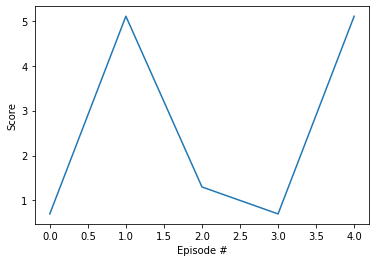

In [14]:

def ddpg_test(n_episodes=5, max_t=5000):
    scores_deque = deque(maxlen=100)
    scores_list = []
    moving_average = []
    best_score = -np.Inf
    best_episode = 0
    for i_episode in range(1, n_episodes+1):
        # Reset the agent's state.
        env_info = env.reset(train_mode=False)[brain_name]
        # Get the current state.
        states = np.reshape(env_info.vector_observations, (1, 48))
        # Reset the agent's noise parameter.
        agents.reset()
        scores = np.zeros(num_agents)
        # For each time step in episode, get action, act, and learn.
        for t in range(max_t):
            actions = agents.act(states, add_noise=False)        # select an action
            actions = np.clip(actions, -1, 1)
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = states = np.reshape(env_info.vector_observations, (1, 48))          # get next state
            rewards = env_info.rewards                          # get reward
            dones = env_info.local_done                         # see if episode has finished
            
            # Generate the agent tuples.
            state_set = states.copy().ravel()
            next_state_set = next_states.copy().ravel()
            action_set = actions.copy().ravel()
            reward_set = rewards
            dones = dones
            
            # Take single optimization step using the collective state update tuple. 
            states = next_states
            scores += np.max(rewards)        
            if np.any(dones):                                   # exit loop when episode ends
                break

        # Add final score to the scores queue.
        ep_best_score = np.max(scores)
        scores_deque.append(ep_best_score)
        scores_list.append(ep_best_score)
        moving_average.append(np.mean(scores_deque))

        # save best score                        
        if ep_best_score > best_score:
            best_score = ep_best_score
            best_episode = i_episode
    
        print('Episodes {}\tMax Reward: {}\tAverage Score: {}'.format(
                i_episode, np.max(scores_list[-10:]), moving_average[-1]))
  
    return scores_list

# Run ddpg algorithm, and save final output.
scores = ddpg_test()

# Plot performance
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('performance.png')
plt.plot()

